# Homework 4

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображенииа, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершут предобработку картинки, писанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер равномерно занимало место, то есть если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в приложении к этому занятию.

<table><tr>
    <td> <img src="https://i.ibb.co/fkScTsg/test_image_01.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/q7PQRtZ/test_image_03.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/StTqhST/test_image_08.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [2]:
%matplotlib inline

# Ваш код
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
# from skimage.feature import canny

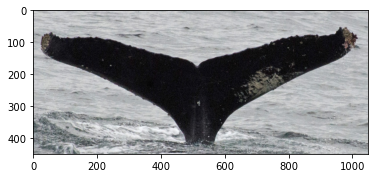

In [3]:
img = cv2.imread("./whale_tail/test_image_00.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [4]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gauss = cv2.GaussianBlur(gray_img, ksize = (5, 5), sigmaX = 100) 
gauss = cv2.equalizeHist(gauss)

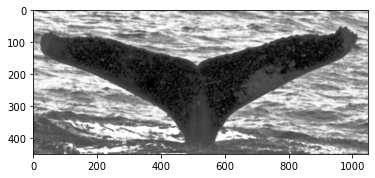

In [5]:
plt.imshow(gauss, cmap = 'gray')

In [6]:
kernel = np.array(
[
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1]
]
,dtype = np.uint8)

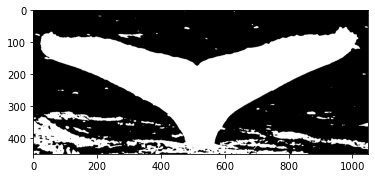

In [7]:
_, bin_contour = cv2.threshold(gauss, 100, 255, cv2.THRESH_BINARY_INV)

plt.imshow(bin_contour, cmap='gray')

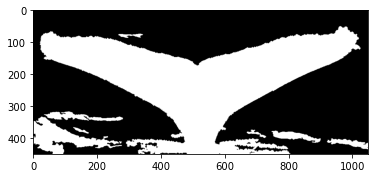

In [8]:
contours, hierarchy = cv2.findContours(bin_contour.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

new_contours = []
for cnt in contours:
    if cnt.shape[0] > 50:
        new_contours.append(cnt)
res = np.zeros_like(bin_contour)
cv2.drawContours(res, max(contours, key=len), -1, 255, 3)
cv2.fillPoly(res, new_contours, 255)
plt.imshow(res, cmap = 'gray')

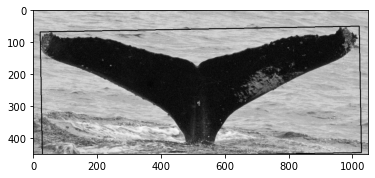

In [9]:
cnt = max(contours, key=len)

img2 = gray_img.copy()

rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img2, [box], 0, (0, 0, 255), 2)

plt.imshow(img2, cmap='gray')

### Напишем функционал для разных форм алгоритма

In [10]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return np.array(images)

In [11]:
# Загрузим картинки
images = load_images_from_folder('whale_tail')
originals = images.copy()
print(images.shape)

(11,)


In [12]:
# Переведём в Grayscale
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)

In [13]:
def plot_images(images):
    fig, axes = plt.subplots(len(images), 1, figsize = (60, 30))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap = 'gray')
        ax.axis('off')
    plt.show()

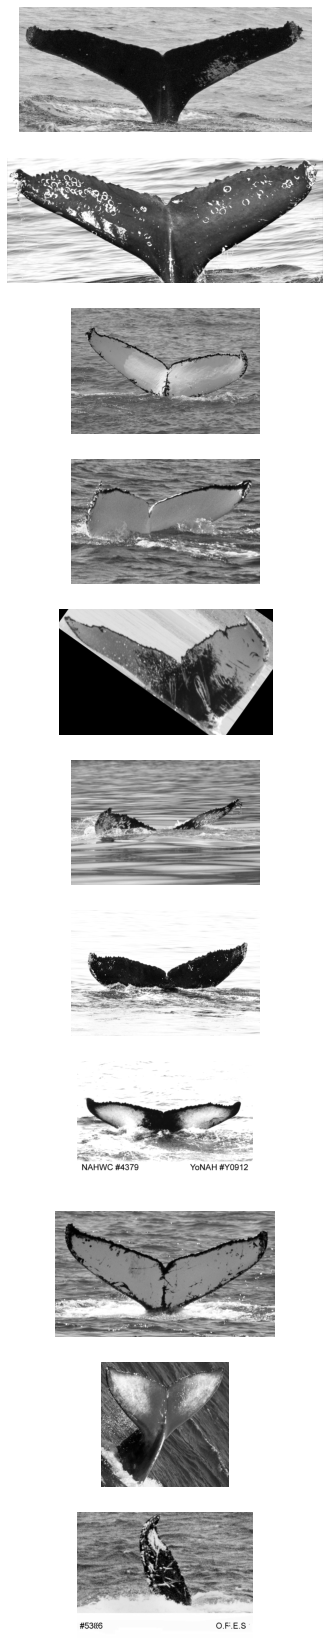

In [14]:
plot_images(images)

In [15]:
def otsu_thresh_image(image, plot = True):
    gauss = cv2.GaussianBlur(image, ksize=(25, 25), sigmaX = 100, sigmaY = 1.) 
    _, thresh = cv2.threshold(gauss, 130, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return thresh

In [16]:
def rotate(angle, image_center):
    def perform_rotation(image):

        height, width = image.shape[:2] # image shape has 3 dimensions
        image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

        rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

        # rotation calculates the cos and sin, taking absolutes of those.
        abs_cos = abs(rotation_mat[0,0]) 
        abs_sin = abs(rotation_mat[0,1])

        # find the new width and height bounds
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)

        # subtract old image center (bringing image back to origo) and adding the new image center coordinates
        rotation_mat[0, 2] += bound_w/2 - image_center[0]
        rotation_mat[1, 2] += bound_h/2 - image_center[1]

        # rotate image with the new bounds and translated rotation matrix
        rotated_mat = cv2.warpAffine(image, rotation_mat, (bound_w, bound_h))
        return rotated_mat
        
        
    return perform_rotation

In [17]:
def get_threshold(image):
    thresh = cv2.adaptiveThreshold(cv2.medianBlur(image, 5), 255, \
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    kernel = np.ones((3, 3),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel, iterations = 4)
    
    return thresh

In [18]:
def get_max_contour(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    return max(contours, key=len)

In [19]:
def bounding_rect(contour): 
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    return box, rect

In [20]:
def contour_work(*args):
    def perform_operations(image):
        poly_filled = image.copy()

        threshold = get_threshold(image)
        contour = get_max_contour(threshold)
        
        if 'convex_fill' in args:
            cv2.fillConvexPoly(poly_filled, contour, 0)
        else:
            cv2.fillPoly(poly_filled, contour, -1)
            cv2.drawContours(poly_filled, contour, 0, 0, -1)
            
        if 'bounding_rect' in args:
            box, rect = bounding_rect(contour)
            center, size, angle = rect
            
            if 'draw_box_filled' in args:
                cv2.drawContours(poly_filled, [box], 0, 0, -1)

            if 'draw_box' in args:
                cv2.drawContours(poly_filled, [box], 0, 0, 3)  
                
            if 'rotate' in args:
                poly_filled = rotate(angle, center)(poly_filled)
            
        if 'fill_white' in args:
            poly_filled[poly_filled != 0] = 1
            poly_filled[poly_filled == 0] = 255
            poly_filled[poly_filled == 1] = 0
        return poly_filled
            
    return perform_operations

In [21]:
def sharpen(image):
    '''
    Unsharp mask algorithm.
    
    \details See https://en.wikipedia.org/wiki/Unsharp_masking
    '''
    blurred = cv2.GaussianBlur(image, (501, 501), 20, 10)
    return cv2.addWeighted(image, 1.1, blurred, -0.1, 128)

In [22]:
def perform_sequence(images, plot = True, *args):
    res = np.array([None for _ in range(len(images))])
    for i in range(len(images)):
        img = images[i].copy()
        for action in args:
            img = action(img)
        res[i] = img
    if plot:
        plot_images(res)
    return res

In [23]:
def bitwise_and(image, mask):
    '''
    \param image: RGB image
    \param mask: 1 channel mask
    '''
    
    img2 = np.zeros_like(image)
    img2[:,:,0] = mask
    img2[:,:,1] = mask
    img2[:,:,2] = mask
    return cv2.bitwise_and(image, img2)

In [24]:
def bitwise_and_images(images, masks):
    ans = np.array([None for _ in range(len(originals))])
    for i in range(len(originals)):
        img = originals[i].copy()
        mask = masks[i]
        img = bitwise_and(img, mask)
        ans[i] = img
    plot_images(ans)

## 1 вариант (без использования контуров)

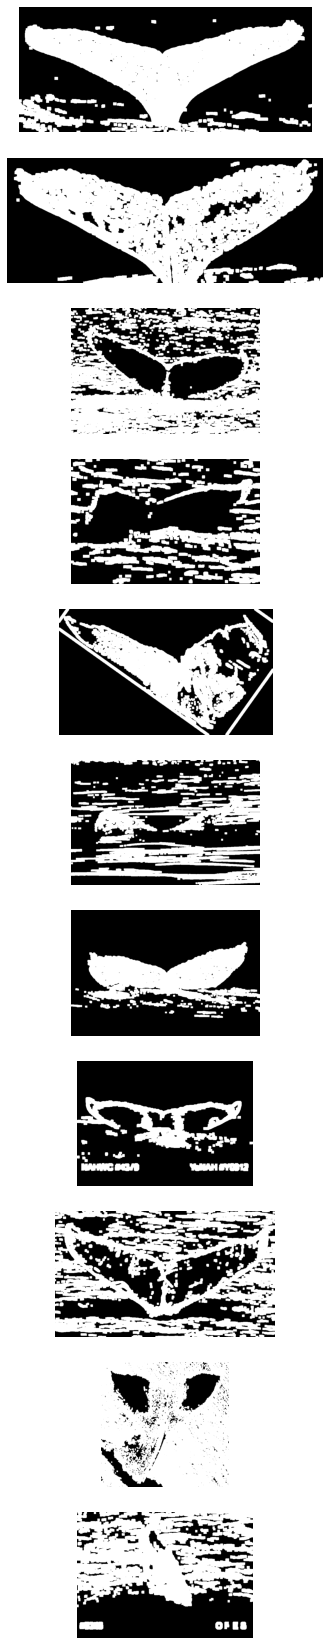

In [25]:
result = perform_sequence(
    images, True,
    sharpen,
    get_threshold,      
)

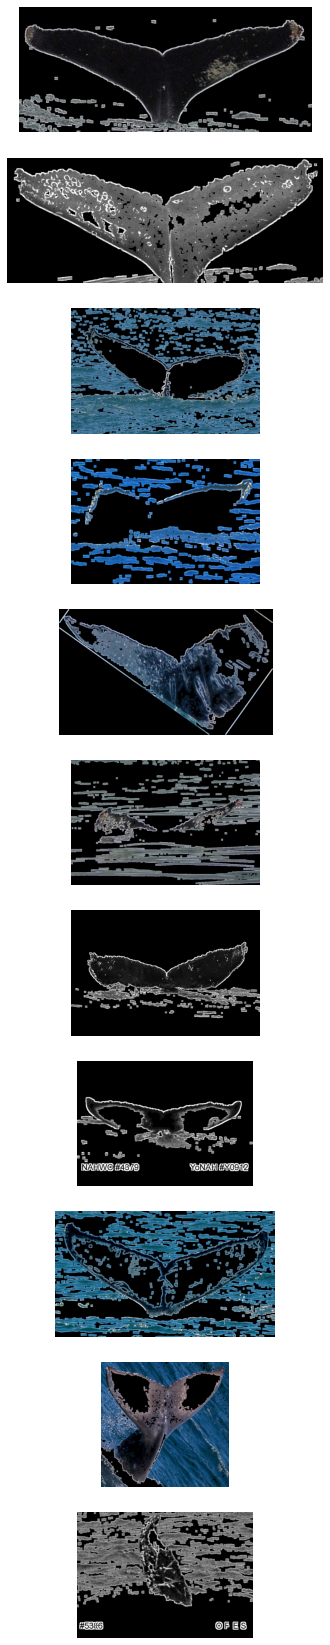

In [26]:
bitwise_and_images(originals, result)

## 2 вариант (с маской как ограничивающим прямоугольником)

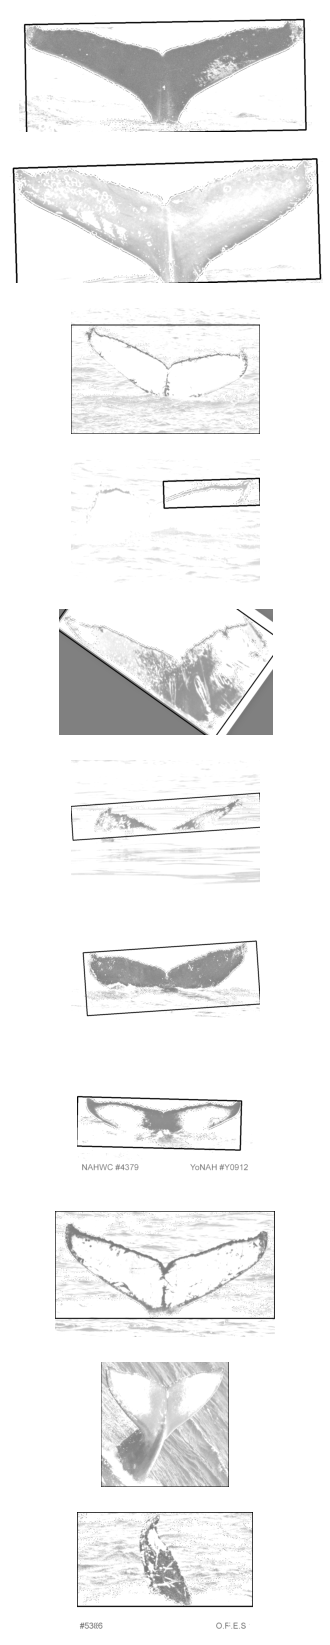

In [27]:
result2 = perform_sequence(
    images, True,
    sharpen, 
    contour_work('bounding_rect', 'draw_box')
)

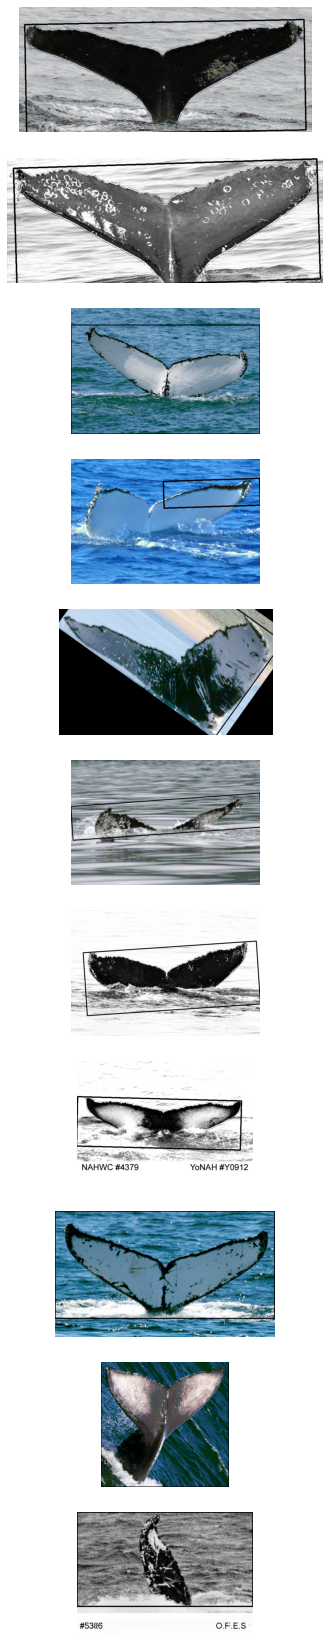

In [28]:
bitwise_and_images(originals, result2)

## 3 вариант (С выделением маски с помощью fillConvexPoly)

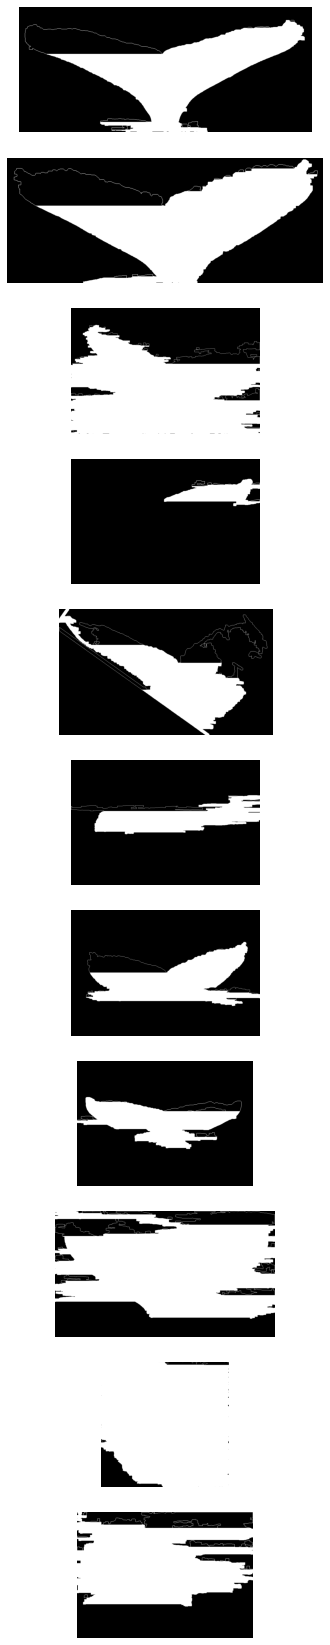

In [29]:
result3 = perform_sequence(
    images, True,
    sharpen,
    contour_work('bounding_rect', 'convex_fill', 'fill_white')
)

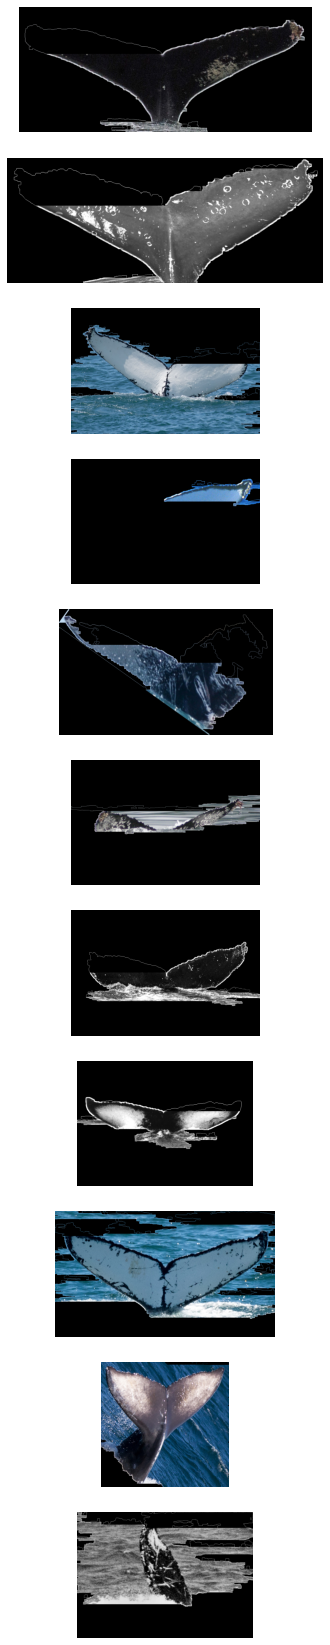

In [30]:
bitwise_and_images(originals, result3)

### Хоть контуры получаются достаточно точными (в том плане, что они охватывают хвост), ```fillPoly``` не может их заполнить так, как хотелось бы (поэтому вариант с его использованием никак не обозначен). ```fillPolyConvex``` отрисовывает их слишком грубо, т.к. наибольший контур помимо хвоста содержит и части воды.

Гиперпараметры алгоритма:

- В ```sharpen``` все числа, кроме последнего, являются гиперпараметрами (в ```addWeighted``` сумма 2 и 4 аргументов должна быть равна 1)
- В ```get_threshold``` гиперпараметр - ядро, размер ядра в ```medianBlur```, последние 2 числа в ```adaptiveThreshold```, число итераций в morphologyEx